In [1]:
# Realize ResNet for digit classification
# Bottleneck -> Block

In [2]:
# Display the result
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import utils
import Block

In [4]:
import os
import time
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers

In [5]:
# Step1 load MNITST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", 
                                  one_hot=True,
                                  validation_size=2000)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
x = tf.placeholder(tf.float32, shape=[None,28,28,1],name='inputs')
y_ = tf.placeholder(tf.float32, shape=[None,10],name='outputs')
is_training = tf.placeholder(tf.bool, name='is_training')

In [7]:
# Reidual nets
net = x
blocks = [
    [(64, 32, 1)]*1 + [(64, 32, 2)],
    [(128, 64, 1)]*1 + [(128, 64, 2)],
]
for i, block in enumerate(blocks):
    block_params = utils.get_block(block, is_training=is_training)
    # build the net
    block_obj = Block.Block(
        inputs = net,
        block_params = block_params,
        is_training = is_training,
        scope = 'block'+str(i),
        summary_flag = True
        )
    net = block_obj.get_block()

In [8]:
# flattern layer
with tf.name_scope('flattern'):
    net = layers.flatten(net)
    tf.summary.histogram('flattern',net)

In [9]:
# Softmax layer
with tf.name_scope('softmax'):
    y = layers.fully_connected(
            net, 10, activation_fn=tf.nn.tanh)
    tf.summary.histogram('softmax',y)

In [10]:
# loss function
with tf.name_scope('loss'):
    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
    tf.summary.scalar('loss', cross_entropy)

In [11]:
# learning rate
with tf.name_scope('learning_rate'):
    init_lr = tf.placeholder(tf.float32, name='LR')
    global_step = tf.placeholder(tf.float32, name="global_step")
    decay_step = tf.placeholder(tf.float32, name="decay_step")
    decay_rate = tf.placeholder(tf.float32, name="decay_rate")
    learning_rate = tf.train.exponential_decay(
        learning_rate = init_lr ,
        global_step = global_step,
        decay_steps = decay_step,
        decay_rate = decay_rate,
        staircase=False,
        name=None)   

In [12]:
# Accuracy
with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(
            tf.argmax(y, 1), tf.argmax(y_, 1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('accuracy', accuracy)

<tf.Tensor 'accuracy_1:0' shape=() dtype=string>

In [13]:
# Merge all the summaries and write to logdir
logdir = './log'
if not os.path.exists(logdir):
    os.mkdir(logdir)
merged = tf.summary.merge_all()
# Initialize the variables
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
train_writer = tf.summary.FileWriter(logdir + '/train',
                                      sess.graph)
val_writer = tf.summary.FileWriter(logdir + '/validation',
                                   sess.graph)
test_writer = tf.summary.FileWriter(logdir + '/test',
                                   sess.graph)

In [14]:
def feed_dict(train,batchsize=100,drop=0.5, lr_dict=None):
    """Make a TensorFlow feed_dict: maps data onto Tensor placeholders."""
    if train:
        xs, ys = mnist.train.next_batch(batchsize)
        f_dict = {x: xs.reshape([-1,28,28,1]), y_: ys, 
                  is_training: True}
        f_dict.update(lr_dict)
    else:    
        # validation
        x_val,y_val = mnist.validation.images,mnist.validation.labels
        f_dict = {x: x_val.reshape([-1,28,28,1]),y_: y_val,
                  is_training: False}
    return f_dict

In [15]:
def test_dict():
    xs, ys = mnist.test.images, mnist.test.labels
    f_dict = {x: xs.reshape([-1, 28, 28, 1]), y_: ys, 
              is_training: False}
    return f_dict

In [16]:
# Train step 
# note: should add update_ops to the train graph
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    with tf.name_scope('train'):
        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy) 

In [17]:
# Training the model by repeatedly running train_step
import time 
epochs = 100
batchsize= 100
# num_batches = mnist.train.images.shape[0] // batchsize
num_batches = 200

lr_init = 0.01
d_rate = 0.9

x_epoch = np.arange(0,epochs,1)
y_loss_trn = np.zeros(x_epoch.shape)
y_acc_trn = np.zeros(x_epoch.shape)
y_loss_val = np.zeros(x_epoch.shape)
y_acc_val = np.zeros(x_epoch.shape)
y_acc_test = np.zeros(x_epoch.shape)

# Init all variables
timestamp = time.strftime('%Y-%m-%d: %H:%M:%S', time.localtime(time.time()))
print("[%s]: Epochs    Trn_loss    Val_loss    Trn_acc    Val_acc    Test_acc" % (timestamp))
for i in range(epochs):
    lr_dict = {init_lr: lr_init, global_step:i,
               decay_step: i, decay_step: batchsize,
               decay_rate: d_rate}
    loss_trn_all = 0.0
    acc_trn_all = 0.0
    for b in range(num_batches):
        train_dict = feed_dict(True,lr_dict=lr_dict)
        # train
        summary_trn, _, acc_trn, loss_trn = sess.run(
            [merged, train_step, accuracy, cross_entropy], 
            feed_dict=train_dict)
        loss_trn_all += loss_trn
        acc_trn_all += acc_trn
    
    y_loss_trn[i] = loss_trn_all / num_batches
    y_acc_trn[i] = acc_trn_all / num_batches
    train_writer.add_summary(summary_trn, i)
    # validation
    val_dict = feed_dict(False)
    summary_val, y_acc_val[i], y_loss_val[i] = sess.run(
        [merged, accuracy, cross_entropy],feed_dict=val_dict)
    val_writer.add_summary(summary_val, i)
    summary, y_acc_test[i] = sess.run(
        [merged, accuracy],feed_dict=test_dict())
    test_writer.add_summary(summary, i)
    if i % 10 == 0:
        timestamp = time.strftime('%Y-%m-%d: %H:%M:%S', time.localtime(time.time()))
        print('[%s]: %d    %.4f    %.4f    %.4f    %.4f    %.4f' % (timestamp, i, 
                                                                    y_loss_trn[i], y_loss_val[i],
                                                                    y_acc_trn[i], y_acc_val[i],
                                                                    y_acc_test[i]))

[2018-01-27: 00:04:02]: Epochs    Trn_loss    Val_loss    Trn_acc    Val_acc    Test_acc
[2018-01-27: 00:04:54]: 0    1.8370    1.2844    0.6221    0.8040    0.8231
[2018-01-27: 00:13:19]: 10    0.9414    0.9428    0.9313    0.9325    0.9343
[2018-01-27: 00:21:45]: 20    0.8765    0.8871    0.9617    0.9570    0.9617
[2018-01-27: 00:30:12]: 30    0.8571    0.8653    0.9700    0.9685    0.9715
[2018-01-27: 00:38:38]: 40    0.8482    0.8586    0.9737    0.9690    0.9742
[2018-01-27: 00:47:07]: 50    0.8411    0.8523    0.9792    0.9770    0.9779
[2018-01-27: 00:55:34]: 60    0.8371    0.8457    0.9802    0.9785    0.9820
[2018-01-27: 01:04:00]: 70    0.8309    0.8556    0.9831    0.9720    0.9786
[2018-01-27: 01:12:24]: 80    0.8288    0.8426    0.9834    0.9835    0.9837
[2018-01-27: 01:20:49]: 90    0.8254    0.8413    0.9850    0.9815    0.9840


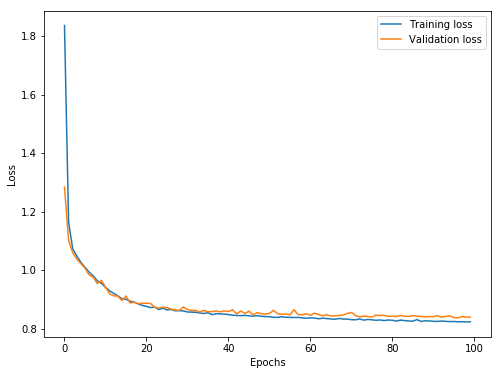

In [18]:
plt.rcParams["figure.figsize"] = [8.0,6.0]

plt.plot(x_epoch, y_loss_trn)
plt.plot(x_epoch, y_loss_val)
plt.legend(['Training loss', 'Validation loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

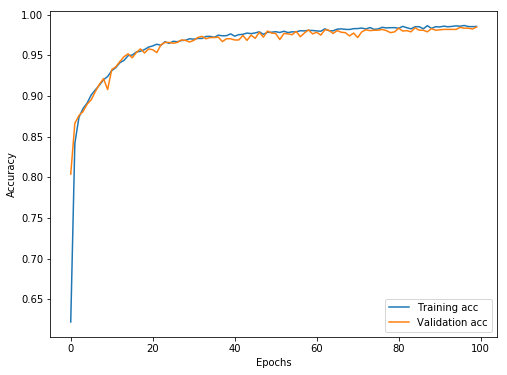

In [19]:
plt.rcParams["figure.figsize"] = [8.0,6.0]

plt.plot(x_epoch, y_acc_trn)
plt.plot(x_epoch, y_acc_val)
plt.legend(['Training acc', 'Validation acc', 'Test acc'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')